In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score


%matplotlib inline
plt.style.use('seaborn-white')

In [4]:
dataset="bank-additional-full.csv"
bankdata=pd.read_csv(dataset, delimiter=";")
bankdata["response"] = bankdata.y.map({'no':0, 'yes':1})

bankdata.drop(["y"],axis=1, inplace=True)
#bankdata.info()
#(bankdata.response==0).sum()

#bankdata.age.unique()

In [5]:
bankdata.head(2)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,response
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0


In [6]:
#The method .copy() is used here so that any changes made in new DataFrame don't get reflected in the original one
cat_bankdata = bankdata.select_dtypes(include=['object']).copy() #dataframe of columns with object type columns

#print(cat_bankdata.isnull().values.sum()) #checking for the null values
#print(cat_bankdata.isnull().sum()) #check the column-wise distribution of null values
int_float_bankdata= bankdata.select_dtypes(include=['int64','float64']).copy() #dataframe of columns with int64,float64 type columns
int_float_bankdata.shape #includes response


(41188, 11)

In [7]:
#converting categories into numeric types(numeric encoding)

cat_column=cat_bankdata.columns.tolist()

for i in cat_column:
    cat_bankdata[i] = cat_bankdata[i].astype('category')
    cat_bankdata[i] = cat_bankdata[i].cat.codes
    
cat_bankdata.head() 

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome
0,3,1,0,0,0,0,1,6,1,1
1,7,1,3,1,0,0,1,6,1,1
2,7,1,3,0,2,0,1,6,1,1
3,0,1,1,0,0,0,1,6,1,1
4,7,1,3,0,0,2,1,6,1,1


In [8]:
from sklearn.feature_selection import VarianceThreshold

var_bankdata=pd.concat([int_float_bankdata,cat_bankdata],axis=1)

#EX/ threshold=0.1 which means that if the variance of the values in a column is less than 0.1, remove those columns.
#In other words, remove feature column where approximately 99% of the values are similar.
variance_filter = VarianceThreshold(threshold=0.1)
bankdata_filtered=variance_filter.fit(var_bankdata)  

#Now to get all the features that are NOT CONSTANT, we can use the get_support() method of the filter that we created
len(var_bankdata.columns[variance_filter.get_support()]) 

#the number of constant features with the help of the following script:
constant_columns = [column for column in var_bankdata.columns  
                    if column not in var_bankdata.columns[variance_filter.get_support()]]

#print(variable_columns)
#print(int_float_bankdata.columns[variance_filter.get_support()])
bankdata_filtered=var_bankdata[var_bankdata.columns[variance_filter.get_support()]]

bankdata_filtered.info()  #not include "response"

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 20 columns):
age               41188 non-null int64
duration          41188 non-null int64
campaign          41188 non-null int64
pdays             41188 non-null int64
previous          41188 non-null int64
emp.var.rate      41188 non-null float64
cons.price.idx    41188 non-null float64
cons.conf.idx     41188 non-null float64
euribor3m         41188 non-null float64
nr.employed       41188 non-null float64
job               41188 non-null int8
marital           41188 non-null int8
education         41188 non-null int8
default           41188 non-null int8
housing           41188 non-null int8
loan              41188 non-null int8
contact           41188 non-null int8
month             41188 non-null int8
day_of_week       41188 non-null int8
poutcome          41188 non-null int8
dtypes: float64(5), int64(5), int8(10)
memory usage: 3.5 MB


In [9]:
constant_columns

['response']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000FFD4699358>,
      dtype=object)

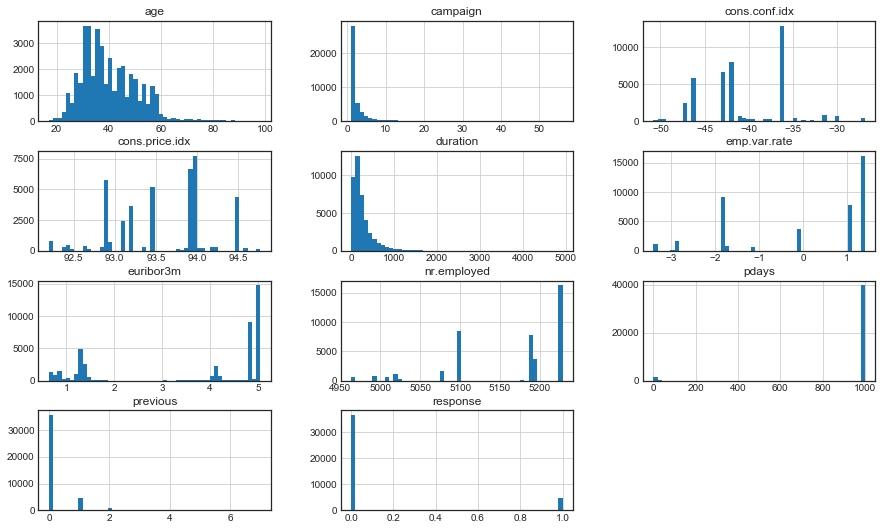

In [9]:
int_float_bankdata.hist(figsize=(15,9),bins=50)

In [14]:
#creating dummy variables from categorical features (One-Hot encoding)>> this has the benefit of not weighting a value improperly.
#sklearn has "LabelBinarizer" class for one- hot encoding

cat_bankdata_dummy = cat_bankdata.copy()
cat_column_list=cat_bankdata.columns.tolist()

cat_bankdata_dummy = pd.get_dummies(cat_bankdata_dummy, columns=cat_column_list, prefix = cat_column_list,drop_first=True)


#print(cat_bankdata_dummy.info())

In [12]:
int_float_bankdata.head()

#int_float_bankdata.drop(columns=["response"])
 


,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,response
0,56,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0
1,57,149,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0
2,37,226,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0
3,40,151,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0
4,56,307,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0


In [15]:
#Concatenating back with the remaining columns, which can be done via pandas' .concat() method. 
#The axis argument is set to 1 as you want to merge on columns.

resulting_bankdata = pd.concat([cat_bankdata_dummy, int_float_bankdata], axis=1)
resulting_feature_set=resulting_bankdata.drop(["response"],axis=1) #response variable excluded

#len(resulting_feature_set.columns.values)


In [16]:
resulting_feature_set.head()

,job_1,job_2,job_3,job_4,job_5,job_6,job_7,job_8,job_9,job_10,...,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,0,0,1,0,0,0,0,0,0,0,...,56,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0
1,0,0,0,0,0,0,1,0,0,0,...,57,149,1,999,0,1.1,93.994,-36.4,4.857,5191.0
2,0,0,0,0,0,0,1,0,0,0,...,37,226,1,999,0,1.1,93.994,-36.4,4.857,5191.0
3,0,0,0,0,0,0,0,0,0,0,...,40,151,1,999,0,1.1,93.994,-36.4,4.857,5191.0
4,0,0,0,0,0,0,1,0,0,0,...,56,307,1,999,0,1.1,93.994,-36.4,4.857,5191.0


In [17]:
correlated_features = set()   #creating empty set
correlation_matrix = int_float_bankdata.corr()  

print(correlation_matrix)

for i in range(len(correlation_matrix.columns)):  
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

#print(correlated_features)
#These correlated columns convey similar information to the learning algorithm and therefore, should be removed            

#The following script removes these columns from the dataset:


resulting_feature_set.drop(columns=list(correlated_features), axis=1, inplace=True)  


                     age  duration  campaign     pdays  previous  \
age             1.000000 -0.000866  0.004594 -0.034369  0.024365   
duration       -0.000866  1.000000 -0.071699 -0.047577  0.020640   
campaign        0.004594 -0.071699  1.000000  0.052584 -0.079141   
pdays          -0.034369 -0.047577  0.052584  1.000000 -0.587514   
previous        0.024365  0.020640 -0.079141 -0.587514  1.000000   
emp.var.rate   -0.000371 -0.027968  0.150754  0.271004 -0.420489   
cons.price.idx  0.000857  0.005312  0.127836  0.078889 -0.203130   
cons.conf.idx   0.129372 -0.008173 -0.013733 -0.091342 -0.050936   
euribor3m       0.010767 -0.032897  0.135133  0.296899 -0.454494   
nr.employed    -0.017725 -0.044703  0.144095  0.372605 -0.501333   
response        0.030399  0.405274 -0.066357 -0.324914  0.230181   

                emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  \
age                -0.000371        0.000857       0.129372   0.010767   
duration           -0.027968       

In [18]:
print(correlated_features)

{'euribor3m', 'nr.employed'}


In [25]:
from sklearn.model_selection import train_test_split
#It’s necessary to use stratify when the labels are imbalanced 

X_train, X_test, y_train, y_test = train_test_split(resulting_feature_set, bankdata["response"], test_size=0.3, random_state=0,stratify=bankdata["response"])

In [26]:
from imblearn.over_sampling import SMOTENC #dealing with mixed data type such as continuous and categorical features
smote_nc = SMOTENC(categorical_features=list(range(0,44)), random_state=0)
X_train, y_train = smote_nc.fit_resample(X_train, y_train)

In [ ]:
#data_dmatrix = xgb.DMatrix(data=X,label=y)


In [ ]:
print(X_train_xgb.shape,X_test_xgb.shape)

In [24]:
from imblearn.combine import SMOTETomek 
from collections import Counter

smt = SMOTETomek(random_state=42)
X_train_xgb, y_train_xgb = smt.fit_resample(X_train_xgb, y_train_xgb)


print(sorted(Counter(y_train_xgb).items()))

[(0, 25480), (1, 25480)]


In [27]:
#GRIDSEARCH

from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

xgb_classifier=XGBClassifier(objective='binary:logistic',n_estimators=100)

parameters = {'max_depth' : [2,3,4,5,6],
              'learning_rate' : [0.05,0.1,0.2,0.3],
              "booster" : ["gbtree","dart"]
             }

classif_xgb = RandomizedSearchCV(xgb_classifier, parameters, cv=5, return_train_score=True, scoring="accuracy",random_state=0)
classif_xgb.fit(X_train, y_train)



RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, scale_pos_weight=1,
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
          

In [28]:
print("Best parameters :" , classif_xgb.best_params_, "\n")
print("Best score :" , classif_xgb.best_score_, "\n")
pd.DataFrame(classif_xgb.cv_results_).head()
    

Best parameters : {'max_depth': 6, 'learning_rate': 0.05, 'booster': 'gbtree'} 

Best score : 0.9193800570691475 



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_learning_rate,param_booster,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,54.533879,3.829355,0.149335,0.019806,4,0.05,dart,"{'max_depth': 4, 'learning_rate': 0.05, 'boost...",0.807016,0.948114,...,0.917758,0.055419,3,0.971758,0.934819,0.934648,0.934089,0.935359,0.942135,0.014817
1,32.279225,2.219404,0.155763,0.119498,2,0.05,dart,"{'max_depth': 2, 'learning_rate': 0.05, 'boost...",0.859586,0.919679,...,0.906383,0.023507,10,0.929371,0.910583,0.909777,0.911296,0.911834,0.914572,0.007431
2,31.389315,1.212860,0.103237,0.012784,2,0.1,dart,"{'max_depth': 2, 'learning_rate': 0.1, 'booste...",0.814442,0.940004,...,0.913732,0.049666,9,0.956611,0.926512,0.925266,0.926467,0.927371,0.932445,0.012101
3,49.852671,2.519928,0.212875,0.021038,6,0.05,gbtree,"{'max_depth': 6, 'learning_rate': 0.05, 'boost...",0.764315,0.959840,...,0.919380,0.077561,1,0.986392,0.946497,0.946203,0.947061,0.945986,0.954428,0.015986
4,22.597784,2.477232,0.111208,0.028064,2,0.2,gbtree,"{'max_depth': 2, 'learning_rate': 0.2, 'booste...",0.761188,0.954661,...,0.915979,0.077416,7,0.976962,0.934819,0.935014,0.937045,0.935506,0.943869,0.016565


In [29]:
from sklearn.model_selection import StratifiedKFold

folds = 3

xgb_class=XGBClassifier(objective='binary:logistic',n_estimators=500,learning_rate=0.02, )
xgb_class.fit(X_train,y_train)

folds = 3
parameters = {'max_depth' : [4,5,6],
              'learning_rate' : [0.01,0.02,0.1],
              }
skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb_class, param_distributions=parameters, n_iter=5, scoring='f1', n_jobs=4, cv=skf.split(resulting_feature_set,bankdata["response"]), verbose=3, random_state=1001)
random_search.fit(X_train,y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed: 33.0min finished


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x00000044C2A8BC78>,
                   error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.02, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=500,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, scale_pos_weight=1,
                                           seed=None, silent=None, subs

In [30]:
xgb_model = random_search.best_estimator_ 
xgb_model.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [31]:
X_test=np.asarray(X_test)

In [32]:
# Make predictions
y_pred = xgb_class.predict(X_test)

#y_pred = xgb_model.predict(X_test)
#preds_xgb = pd.Series(preds_xgb)


In [35]:
from sklearn.metrics import precision_score, recall_score, f1_score, balanced_accuracy_score ,confusion_matrix
#from imblearn.metrics import geometric_mean_score
#For any classifier, there is always a trade off between true positive rate and true negative rate; and the
#same applies for recall and precision


# In many applications such as drug discovery and disease diagnosis, it is desirable
#to have a classifier that gives high prediction accuracy over the minority class (Acc+), while maintaining
#reasonable accuracy for the majority class (Acc−). Weighted Accuracy is often used in such situations.
#Weights can be adjusted to suit the application. Here we use equal weights for both true positive rate and
#true negative rate; i.e., β equals 0.5

print(confusion_matrix(y_test, y_pred))
print()
print("f1 : ", f1_score(y_test, y_pred,average="binary"))
print("recall : " ,recall_score(y_test, y_pred))
print("precision : " ,precision_score(y_test, y_pred))
print("weighted_accuracy : " ,balanced_accuracy_score(y_test, y_pred))
#print("G_mean : " , geometric_mean_score(y_test, y_pred))

[[10072   893]
 [  391  1001]]

f1 :  0.6092513694461351
recall :  0.7191091954022989
precision :  0.5285110876451954
weighted_accuracy :  0.8188341234649433


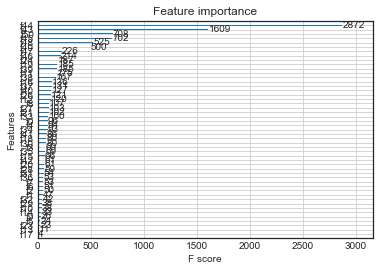

In [36]:
import matplotlib.pyplot as plt
import xgboost as xgb
xgb.plot_importance(xgb_model)
plt.rcParams['figure.figsize'] = [20, 10]
plt.show()

In [37]:
y_pred = xgb_model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print("Area under ROC curve = {:0.2f}".format(roc_auc),"\n") 

print("Roc_auc_score = {:0.2f}".format(roc_auc_score(y_test, y_pred)),"\n") 


# Generate table of predictions
contingency_table = pd.crosstab(preds, y_test ,margins=True)
print(contingency_table)

Area under ROC curve = 0.76 

Roc_auc_score = 0.76 



NameError: name 'preds' is not defined

In [44]:
from sklearn.metrics import classification_report, confusion_matrix  


print(confusion_matrix(y_pred_xgb, y_test_xgb))  
print(classification_report(y_pred_xgb, y_test_xgb)) 

[[10478   620]
 [  487   772]]
              precision    recall  f1-score   support

           0       0.96      0.94      0.95     11098
           1       0.55      0.61      0.58      1259

   micro avg       0.91      0.91      0.91     12357
   macro avg       0.76      0.78      0.77     12357
weighted avg       0.91      0.91      0.91     12357



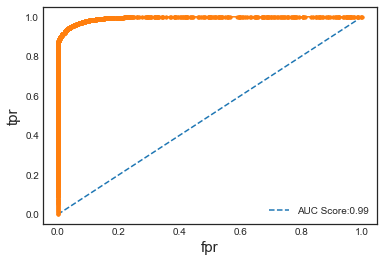

AUC: 0.993


In [32]:
#ROC_CURVE (an accuarte metrics for balanced data)

y_pred_prob_xgb = xgb_model.predict_proba(X_test_xgb)
fpr, tpr, thresholds = roc_curve(y_test_xgb, y_pred_prob_xgb[:,1])
auc_score = roc_auc_score(y_test_xgb, y_pred_prob_xgb[:,1])
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.xlabel('fpr',fontsize='15')
plt.ylabel('tpr',fontsize='15')
plt.legend(["AUC Score:" + "{0:.2f}".format(auc_score)],)
plt.show()

print('AUC: %.3f' % auc_score)


In [33]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

kfold = StratifiedKFold(n_splits=5,shuffle=True,random_state=7)
accuracy = cross_val_score(xgb_model,X_train_xgb, y_train_xgb,cv=list(kfold.split(X_train_xgb, y_train_xgb)),scoring="roc_auc")
print ("Cross-validated scores:", accuracy)

Cross-validated scores: [0.99253331 0.99242956 0.99238856 0.99305783 0.9924965 ]


In [34]:
accuracy.mean()

0.9925811538139657

In [35]:
from sklearn.model_selection import StratifiedShuffleSplit #This does not try to make folds with testing sets that are mutually exclusive

sss = StratifiedShuffleSplit(n_splits = 5,test_size=0.25)
accuracy = cross_val_score(xgb_model,X_train_xgb, y_train_xgb,cv=list(sss.split(X_train_xgb, y_train_xgb)),scoring="roc_auc")
print ("Cross-validated scores:", accuracy)

Cross-validated scores: [0.99265078 0.99295515 0.99247859 0.99235891 0.99199454]


In [20]:
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=0)
acc_shuffle=cross_val_score(xgb_model,X_train_xgb, y_train_xgb,scoring="roc_auc", cv=cv)  
print ("Cross-validated scores:", acc_shuffle)  #he Accuracy of the model is the average of the accuracy of each fold.
print("Accuracy: %0.2f (+/- %0.2f)" % (acc_shuffle.mean(), acc_shuffle.std() * 2))


Cross-validated scores: [0.93747837 0.93969291 0.93612171 0.93776956 0.93495027 0.93795293
 0.93699947 0.9388117  0.93682835 0.93648154]
Accuracy: 0.94 (+/- 0.00)


In [96]:
#OR >>
roc_accuracy = cross_val_score(xgb_model,X_train_xgb, y_train_xgb,scoring="roc_auc", cv=12)
print ("Cross-validated scores:", roc_accuracy)  #he Accuracy of the model is the average of the accuracy of each fold.
print("Accuracy: %0.2f (+/- %0.2f)" % (roc_accuracy.mean(), roc_accuracy.std() * 2))

Cross-validated scores: [0.93463382 0.94355752 0.93927409 0.94451453 0.94365938 0.94444809
 0.93593887 0.94006346 0.94461375 0.93530923 0.93575869 0.93855667]
Accuracy: 0.94 (+/- 0.01)


In [37]:
y_pred_rs = xgb_model.predict(X_test_xgb)
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test_xgb, y_pred_rs)

array([[10538,   427],
       [  605, 10359]], dtype=int64)

In [40]:
from sklearn.metrics import classification_report, confusion_matrix  


print(confusion_matrix(y_test_xgb, preds_xgb,labels = [1,0]))  
print(classification_report(y_test_xgb, preds_xgb))

#Precision and Recall metrics are appropriate when you are dealing with imbalanced datasets
#F1 > harmonic mean of precision and recall

[[10359   605]
 [  427 10538]]
              precision    recall  f1-score   support

           0       0.95      0.96      0.95     10965
           1       0.96      0.94      0.95     10964

   micro avg       0.95      0.95      0.95     21929
   macro avg       0.95      0.95      0.95     21929
weighted avg       0.95      0.95      0.95     21929

